First:
- go to the terminal
- go to the `4_tuning_networks` folder, use `cd` to get there, or `z` to get there faster.
- if you are planning on closing the laptop to let this run by itself, start a tmux session by giving the command `tmux`. You can name the session with `ctrl+b $`, leave the tmux with `ctrl+b` d, access it again with `tmux a -t 0` or replace the 0 with the name you gave it. See [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) for more info.
- Activate the `.venv`, and run `python hypertune.py`
- In the hypertune.py file, a tune_dir is specified: `models/ray`. We will check the contents of that folder after the hypertune finished. You can also use tensorboard to check the results. 
- this will take some time. I clocked 1901 seconds (30 minutes) on the VM

 0.0992908 |           119 |            3 |     26 |         576.744  |    0 |   0.942187

In [49]:
from pathlib import Path
tune_dir = Path("../models/ray").resolve()
tune_dir.exists()

True

In [50]:
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
latest = tunelogs[-1]
latest

PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/models/ray/train_2024-07-03_19-32-07')

In [51]:
from ray.tune import ExperimentAnalysis
import ray
ray.init(ignore_reinit_error=True)


analysis = ExperimentAnalysis(latest)


2024-07-03 20:44:31,637	INFO worker.py:1586 -- Calling ray.init() again after it has already been called.


2024-07-03 20:44:32,031	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_4c25e046: FileNotFoundError('Could not fetch metrics for train_4c25e046: both result.json and progress.csv were not found at /home/azureuser/code/mads-exam-24-FalcovdHoogen/models/ray/train_2024-07-03_19-32-07/train_4c25e046_42_data_dir=ref_ph_5a725494,dropout_rate=0.1667,hidden=76,num_classes=2,num_layers=5,shape=16_12,tune_dir=ref_ph_b1_2024-07-03_20-39-36')


So, we find some info:

In [52]:
analysis.results_df.columns


Index(['iterations', 'train_loss', 'test_loss', 'Accuracy', 'F1scoremicro',
       'F1scoremacro', 'Precisionmicro', 'Recallmacro', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/hidden', 'config/num_layers', 'config/tune_dir',
       'config/data_dir', 'config/num_classes', 'config/dropout_rate',
       'config/shape'],
      dtype='object')

Let's focus on the parameters we wanted to tune.

In [53]:
import plotly.express as px

plot = analysis.results_df
select = ["Recallmacro", "iterations", 'config/num_layers', "config/hidden", "config/dropout_rate"]
p = plot[select].reset_index().dropna()


Let's sort by accuracy

In [54]:
p.sort_values("Recallmacro", inplace=True)

Make a parallel plot

In [55]:
px.parallel_coordinates(p, color="Recallmacro")


<Axes: xlabel='config/hidden', ylabel='config/dropout_rate'>

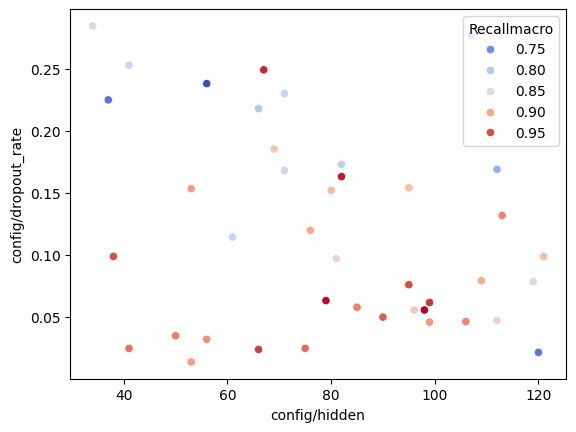

In [56]:
import seaborn as sns

sns.scatterplot(data=p, x="config/hidden", y="config/dropout_rate", hue="Recallmacro", palette="coolwarm")

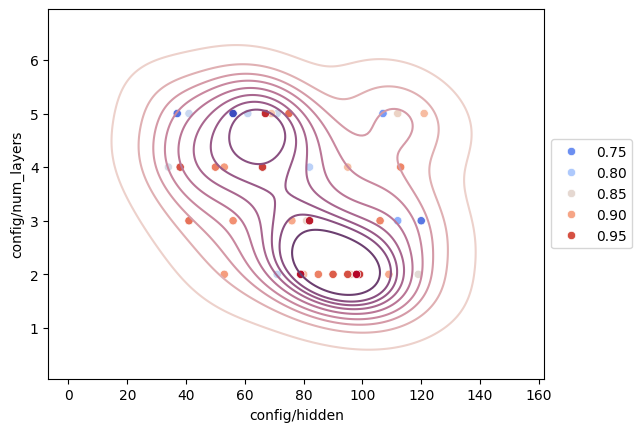

In [57]:
import matplotlib.pyplot as plt
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data=p, x="config/hidden", y="config/num_layers", hue="Recallmacro", palette="coolwarm")
sns.kdeplot(data=p, x="config/hidden", y="config/num_layers", cmap=cmap)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Get the best trial

In [58]:
analysis.get_best_trial(metric="Recallmacro", mode="max")


train_16673256

The top ten

In [59]:
p[-10:]


,trial_id,Recallmacro,iterations,config/num_layers,config/hidden,config/dropout_rate
36,f2630fa7,0.936034,4.0,5.0,75.0,0.024639
40,55e7cd73,0.942931,1.0,2.0,90.0,0.049848
22,4430c6b5,0.948084,2.0,4.0,38.0,0.098811
0,3b38ef2c,0.949450,2.0,2.0,95.0,0.075966
9,05bb69e0,0.956771,2.0,4.0,66.0,0.023766
21,df96461a,0.959967,2.0,2.0,99.0,0.061579
37,e906b5d5,0.965393,4.0,5.0,67.0,0.249272
34,7a3d004b,0.968863,4.0,3.0,82.0,0.163199
35,94133877,0.972622,4.0,2.0,79.0,0.063132
38,16673256,0.975054,4.0,2.0,98.0,0.055565


Or the best config

In [60]:
analysis.get_best_config(metric="Accuracy", mode="max")


{'hidden': 98,
 'num_layers': 2,
 'tune_dir': PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/models/ray'),
 'data_dir': PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/data'),
 'num_classes': 2,
 'dropout_rate': 0.05556474971380084,
 'shape': [16, 12]}